## Data

Спочатку завантажуємо word embeddings для української мови.

In [1]:
!curl http://lang.org.ua/static/downloads/models/news.lowercased.tokenized.word2vec.300d.bz2 --output news.lowercased.tokenized.word2vec.300d.bz2

In [2]:
!bunzip2 news.lowercased.tokenized.word2vec.300d.bz2

In [13]:
from gensim.models import KeyedVectors

%time wv = KeyedVectors.load_word2vec_format('news.lowercased.tokenized.word2vec.300d', binary=False)

CPU times: user 1min 11s, sys: 560 ms, total: 1min 12s
Wall time: 1min 11s


In [3]:
wv.most_similar('слово')

[('дієслово', 0.6502863764762878),
 ('слівце', 0.6484909653663635),
 ('словосполучення', 0.6456568241119385),
 ('гасло', 0.5913079977035522),
 ('слово**', 0.555127739906311),
 ("прислів'я", 0.5407627820968628),
 ('письмо', 0.5235773324966431),
 ('прізвище', 0.52119380235672),
 ('пророцтво', 0.5125285983085632),
 ('ремесло', 0.5058826804161072)]

Потім розпаковуємо та завантажуємо дані.

In [ ]:
!unzip -q ../../../tasks/1551.zip

replace 1551/Інші-Подяки.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
!ls 1551 | head -n 15

Аварійний--травмонебезпечний-стан-утримання-об-єктів-благоустрою.txt
Бажаючі-отримати--Картки-киянина--КК--.txt
Будівництво-АЗС.txt
Будівництво-в-нічний-час.txt
Будівництво-дооблаштування-дитячого-майданчику.txt
Будівництво--дооблаштування-спортивних-майданчиків.txt
Будівництво-та-реконструкція-об-єктів-освіти.txt
Взаємовідносини-з-сусідами.txt
Вивезення--утилізація-твердих-та-негабаритних-відходів.txt
Видалення-аварійних--пошкоджених-хворобами-дерев.txt
Видача-розрахункових-книжок--квитанцій--довідок.txt
Вилов-безпритульних-тварин.txt
Вирізування--кронування--гілля-дерев.txt
Виток-холодної-води-на-поверхню.txt
Відновлення-благоустрою-після-вик--планових-аварійних-робіт-на-об-єктах-благоуст.txt
ls: write error: Broken pipe


In [1]:
import glob

files = glob.glob("1551/*")

files[:10]

['1551/Незадовільна-температура-ГВП.txt',
 '1551/Незадовільне-обслуговування-в-амбулаторно-поліклінічних-установах.txt',
 '1551/Відсутнє-електропостачання.txt',
 '1551/Порушення-правил-тиші--після-------.txt',
 '1551/Неякісне-ХВП.txt',
 '1551/Нанесення-дорожньої-розмітки.txt',
 '1551/Робота-циркуляційної-системи.txt',
 '1551/Встановлення-світлофора.txt',
 '1551/Завезення-піску-на-дитячий-майданчик.txt',
 '1551/Скошування-трави.txt']

In [2]:
import os
from collections import namedtuple

Document = namedtuple('Document', 'id topic_id tags content')

def parse_tags(file):
    return [tag for tag in os.path.basename(file.name)[:-4].split('-') if tag]

def parse_topic_file(topic_id, filename):
    documents = []    
    with open(filename) as f:
        tags = parse_tags(f)        
        _id = None
        idx = -1        
        for line in f:            
            if line.strip().isnumeric():
                _id = int(line.strip())
                documents.append(Document(_id, topic_id, tags, []))
                idx +=1
                continue
            if not (_id is None) and line.strip():                
                documents[idx].content.append(line.strip())                
    
    return [doc._replace(content = ''.join(doc.content)) for doc in documents]

In [3]:
all_documents = [doc for topic_id, file in enumerate(files) \
                 for doc in parse_topic_file(topic_id, file) if len(doc.content) > 0]

len(all_documents)

114348

In [4]:
all_documents[:3]

[Document(id=2697865, topic_id=0, tags=['Незадовільна', 'температура', 'ГВП'], content='Недогрев горячей воды (вода нормальной температуры подавалась неделю с15 по 23, до этого была частичная подача горячей воды (пару часов вечером и ночью горячая), остальное время теплой), сейчас опять температура порядка 40 градусов. Эта ситуация продолжается на фоне постоянного недогрева батарей в квартире, ДУ 12 ККЕУ  МОУкраины  не реагирует на ситуацию.'),
 Document(id=3170827, topic_id=0, tags=['Незадовільна', 'температура', 'ГВП'], content='Из горячего крана течет холодная вода, в вечернее и утреннее время купаться нет возможности. Необходимо или пересчитывать тарифы или включать горячую воду.'),
 Document(id=3165270, topic_id=0, tags=['Незадовільна', 'температура', 'ГВП'], content='Я поживаю на 6 этаже 9и - этажного дома на протяжении долгого промежутка времени у нас в квартире из крана горячей воды, особенно утром и в первой половине дня течёт если не холодная вода, то вода чуть тёплая. По утр

Тепер фільтруємо документи з українською мовою.

In [5]:
from langdetect import detect
from langdetect.detector import LangDetectException
from tqdm import tqdm_notebook
import os
import pickle

def memoize(filename, compute):  
    
    fullname = filename + '.can'
    
    if os.path.isfile(fullname):
        with open(fullname, 'rb') as f:                        
            return pickle.load(f)
    
    result = compute()
    with open(fullname, 'wb') as f:
        pickle.dump(result, f)
    
    return result

def is_uk(text):
    
    if len(text):
        try:
            return detect(text[:1024]) == 'uk'
        except LangDetectException as e:
            return False
    
    return False

uk_documents = memoize('uk_documents', 
                       lambda: [doc for doc in tqdm_notebook(all_documents) if is_uk(doc.content)])

Дивимся на дані.

In [6]:
import pandas

uk_doc_df = pandas.DataFrame([doc._replace(tags = "-".join(doc.tags)) for doc in uk_documents])

In [172]:
uk_doc_df.head(10)

,id,topic_id,tags,content
0,3152784,0,Незадовільна-температура-ГВП,Відсутнітність горячого водопостачання належно...
1,3143050,0,Незадовільна-температура-ГВП,Добрий вечір.Прошу розібратися з проблемою нев...
2,3142427,0,Незадовільна-температура-ГВП,На моє звернення № Г-6623 відповідь написав ди...
3,3130991,0,Незадовільна-температура-ГВП,Доброго дня! Вже більше двох тижнів гаряче вод...
4,2405990,0,Незадовільна-температура-ГВП,На звернення:Номер звернення:\tГ-6478Зареєстро...
5,3115494,0,Незадовільна-температура-ГВП,"Звертаюсь до Вас стосовно вирішення питання, щ..."
6,3104107,0,Незадовільна-температура-ГВП,Доброго дня!!! Моє звернення від 02.12.14 #Г-1...
7,3091571,0,Незадовільна-температура-ГВП,Протягом останнього тижня гаряча вода недостат...
8,2690156,0,Незадовільна-температура-ГВП,Прошу прийняти необхідні заходи по покращенню ...
9,2748419,0,Незадовільна-температура-ГВП,немає температури гарячої води


In [173]:
uk_doc_df.describe(include='all')

,id,topic_id,tags,content
count,6.182900e+04,61829.000000,61829,61829
unique,NaN,NaN,188,56061
top,NaN,NaN,Відсутність-ГВП,Відсутнє гаряче водопостачання
freq,NaN,NaN,6564,46
mean,3.159625e+06,105.551731,NaN,NaN
std,1.084360e+07,55.922291,NaN,NaN
min,1.000000e+01,0.000000,NaN,NaN
25%,2.841555e+06,58.000000,NaN,NaN
50%,3.083712e+06,121.000000,NaN,NaN
75%,3.245460e+06,150.000000,NaN,NaN


In [174]:
uk_doc_df.groupby(['topic_id', 'tags']).count().sort_values(['id'], ascending = False).head(50)

,,id,content
topic_id,tags,,
138,Відсутність-ГВП,6564,6564
180,Укладання-та-ремонт-асфальтного-покриття,3628,3628
27,Відсутність-опалення,3142,3142
127,Перевірка-дозвільної-документації-демонтаж-кіосків-ларків,2199,2199
67,Прибирання-та-санітарний-стан-територій,2005,2005
79,Технічний-стан-проїжджих-частин-вулиць-та-тротуарів,1303,1303
155,Відновлення-благоустрою-після-вик-планових-аварійних-робіт-на-об-єктах-благоуст,1289,1289
121,Відсутність-освітлення-у-під-їзді-за-відсутності-несправності-лампочок,1256,1256
58,Не-працює-пасажирський-ліфт,1220,1220


Виділяємо лейбли.

In [7]:
import numpy as np

topic_labels = np.array([doc.topic_id for doc in uk_documents])
len(topic_labels)

61829

І розбиваємо дані на тренувальні і тестові.

In [8]:
from sklearn.model_selection import train_test_split

train_documents, test_documents, train_topic_labels, test_topic_labels = \
    train_test_split(uk_documents, topic_labels, random_state = 26, test_size = 0.3, stratify = topic_labels)

In [9]:
print(len(train_documents))
print(len(train_topic_labels))

43280
43280


In [10]:
print(len(test_documents))
print(len(test_topic_labels))

18549
18549


## Baseline

Будуємо бейзлайн, знаходимо суму векторів слів по кожному документу і використовуємо kNN на знайденних векторах. Для порівняння векторів застосовуємо cosine similarity. Перед знаходженням суми векторів, документ токенізується та видаляються stop words. Знайдені вектори нормалізуються, в такому випадку eclidean distance для kNN має той самий ефект що й cosine distance, при цьому алгоритм дозволяє використовувати більш ефективні структури данних, такі як, наприклад, k-d tree.

In [11]:
import tokenize_uk
import string
import html
import re

with open('uk_stop_words.txt') as f:
    STOP_WORDS = f.read().split()
    
EXT_PUNCTUATION = "”...«»№"

def contain_numbers(s):
    return bool(re.search(r'\d', s))

def non_stop_word(word):
    return not (word in string.punctuation or word in EXT_PUNCTUATION \
                or word in STOP_WORDS or contain_numbers(word) or len(word) < 2)

def remove_stop_words(tokens):
    return [token for token in tokens if non_stop_word(token.lower())]

def tokenize_doc(doc):
    return [word.lower() for word in \
            remove_stop_words(tokenize_uk.tokenize_words(html.unescape(doc.content)))]

def normalize_vec(x):
    m = np.max(x)
    if m > 0.0:
        return x/np.sqrt(np.dot(x,x))
    return x
    
def doc_to_sum_vec(doc):
    words = tokenize_doc(doc)    
    vec = np.zeros(300)
    for word in words:
        try:
            vec += wv[word]
        except KeyError as e:            
            pass
        
    return vec

Рахуємо вектори для тренувальних і тестових документів.

In [185]:
train_doc_sum_vecs = np.array([doc_to_sum_vec(doc) for doc in tqdm_notebook(train_documents)])

In [186]:
test_doc_sum_vecs = np.array([doc_to_sum_vec(doc) for doc in tqdm_notebook(test_documents)]) 

Тренуємо модель.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

class Model:
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels):
        self.train_vectors = train_vectors
        self.train_labels = train_labels
        self.test_vectors = test_vectors
        self.test_labels = test_labels
        
    def train(self):
        self.model.fit(self.train_vectors, self.train_labels)
        self.topics_predicted = self.model.predict(self.test_vectors)
        
    def test(self):
        print(classification_report(self.test_labels, self.topics_predicted))  

class KnnModel(Model):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels, n = 1):
        super().__init__(np.array([normalize_vec(doc) for doc in train_vectors]),\
                       train_labels,\
                       np.array([normalize_vec(doc) for doc in test_vectors]),\
                       test_labels)                
        self.model = KNeighborsClassifier(n_neighbors = n, algorithm='kd_tree', metric = 'euclidean', n_jobs = 6)    

In [188]:
knn = KnnModel(train_doc_sum_vecs, train_topic_labels, test_doc_sum_vecs, test_topic_labels)

In [189]:
%time knn.train()

CPU times: user 11min, sys: 0 ns, total: 11min
Wall time: 1min 57s


In [190]:
knn.test()

              precision    recall  f1-score   support

           0       0.46      0.55      0.50       335
           1       0.77      0.80      0.79        41
           2       0.55      0.30      0.39        79
           3       0.38      0.28      0.32        39
           4       0.88      0.32      0.47        22
           5       0.42      0.30      0.35       106
           6       0.22      0.32      0.26       142
           7       0.25      0.32      0.28        62
           8       0.81      0.43      0.57        30
           9       0.40      0.36      0.38        22
          10       0.57      0.53      0.55       144
          11       0.21      0.17      0.19        29
          12       0.44      0.36      0.40        22
          13       0.33      0.31      0.32        45
          14       0.23      0.18      0.20        84
          15       0.40      0.25      0.31        16
          16       0.51      0.48      0.49       122
          17       0.25    

## Imrovements

Намагаємося покращити результат. Спочатку будемо використовувати логістичну регресію, потім проробимо все те саме але з векторами Doc2Vec.

In [191]:
from sklearn.linear_model import LogisticRegression

class LogregModel(Model):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels, iters = 3000):
        super().__init__(train_vectors, train_labels, test_vectors, test_labels)
        self.model = LogisticRegression(random_state=26, n_jobs = 6, solver="lbfgs", \
                                        multi_class="multinomial", max_iter = iters)

In [192]:
logreg = LogregModel(train_doc_sum_vecs, train_topic_labels, test_doc_sum_vecs, test_topic_labels)

In [193]:
%time logreg.train()

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 38min 23s


In [194]:
logreg.test()

              precision    recall  f1-score   support

           0       0.65      0.53      0.59       335
           1       0.81      0.83      0.82        41
           2       0.46      0.52      0.49        79
           3       0.41      0.36      0.38        39
           4       0.37      0.32      0.34        22
           5       0.62      0.47      0.53       106
           6       0.31      0.19      0.24       142
           7       0.35      0.58      0.43        62
           8       0.75      0.50      0.60        30
           9       0.48      0.55      0.51        22
          10       0.62      0.69      0.65       144
          11       0.20      0.31      0.24        29
          12       0.83      0.45      0.59        22
          13       0.28      0.33      0.31        45
          14       0.14      0.12      0.13        84
          15       0.38      0.50      0.43        16
          16       0.56      0.55      0.56       122
          17       0.80    

Є невелике покращення в якості. Переходимо до Doc2Vec. Для цього використовуємо gensim. Спочатку конвертуємо наші документи в модель gensim.

In [13]:
from gensim.models.doc2vec import TaggedDocument

def to_tagged_doc(doc):
    words = tokenize_doc(doc)
    return TaggedDocument(words, [doc.topic_id])

In [14]:
to_tagged_doc(uk_documents[15])

TaggedDocument(words=['заявляю', 'чергове', 'втручання', 'діяльність', 'інформаційної', 'системи', 'колцентру', 'метою', 'викривлення', 'відомостей', 'стосовно', 'результатів', 'вирішення', 'поданих', 'звернень', 'даний', 'відмітку', 'виконано', 'наводжу', 'витяг', 'березня', 'перегляд', 'інтерактивній', 'картівідсутність', 'гвп', 'відповідальний', 'кп', 'печерська', 'брама', 'мазурчак', 'олександр', 'володимирович', 'дата', 'контролю', 'березня', 'статус', 'виконано', 'відповідаю', 'дійсності', 'оскільки', 'годин', 'офіційно', 'отриманий', 'електронний', 'запит', 'виклав', 'текст', 'протилежного', 'змісту', 'наводжу', 'заявника', 'квітня', 'статус', 'виконано', 'квартира', 'розташована', 'му', 'під’їзді', 'відношення', 'перекриття', 'стояка', 'го', 'заміна', 'вентиля', 'сусідів', 'потребує', 'перекриття', 'водопостачання', 'будинку', 'викличе', 'появу', 'трубах', 'будинку', 'стільки', 'бруду', 'зливався', 'понад', 'хвилини', 'хвилину', 'вигаданих', 'нормативів', 'кму', 'скарги', 'взаг

In [15]:
train_tagged_docs = [to_tagged_doc(doc) for doc in tqdm_notebook(train_documents)]

In [16]:
test_tagged_docs = [to_tagged_doc(doc) for doc in tqdm_notebook(test_documents)]

Потім тренуємо PV-DBOW модель. Розмір вектору документа 300, як і в моделі з embeddins, яку ми використовували в бейзлайні.

In [199]:
from gensim.models.doc2vec import Doc2Vec

dbow_model = Doc2Vec(dm=0, vector_size=300, min_count=5, window=10, workers=6, epochs=120)

dbow_model.build_vocab(train_tagged_docs + test_tagged_docs)

In [200]:
%time dbow_model.train(train_tagged_docs, total_examples=dbow_model.corpus_count, epochs=dbow_model.epochs)

CPU times: user 12min 30s, sys: 47.8 s, total: 13min 17s
Wall time: 4min 57s


Збираємо вектори документів.

In [201]:
train_doc_vecs = np.array([dbow_model.infer_vector(doc.words) for doc in tqdm_notebook(train_tagged_docs)])

In [202]:
test_doc_vecs = np.array([dbow_model.infer_vector(doc.words) for doc in tqdm_notebook(test_tagged_docs)])

Знову намагаємося застосувати kNN та логістичну регресію на отриманних векторах.

In [203]:
knn2 = KnnModel(train_doc_vecs, train_topic_labels, test_doc_vecs, test_topic_labels)

In [204]:
%time knn2.train()

CPU times: user 12min 13s, sys: 51 ms, total: 12min 13s
Wall time: 2min 7s


In [205]:
knn2.test()

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       335
           1       0.83      0.83      0.83        41
           2       0.57      0.52      0.54        79
           3       0.48      0.54      0.51        39
           4       0.57      0.55      0.56        22
           5       0.55      0.77      0.64       106
           6       0.43      0.32      0.36       142
           7       0.53      0.52      0.52        62
           8       0.37      0.93      0.53        30
           9       0.51      0.82      0.63        22
          10       0.78      0.85      0.81       144
          11       0.67      0.21      0.32        29
          12       0.94      0.73      0.82        22
          13       0.66      0.51      0.57        45
          14       0.32      0.17      0.22        84
          15       0.44      0.44      0.44        16
          16       0.50      0.63      0.56       122
          17       0.40    

In [206]:
logreg2 = LogregModel(train_doc_vecs, train_topic_labels, test_doc_vecs, test_topic_labels)

In [207]:
%time logreg2.train()

CPU times: user 334 ms, sys: 756 ms, total: 1.09 s
Wall time: 7min 15s


In [208]:
logreg2.test()

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       335
           1       1.00      0.63      0.78        41
           2       0.51      0.48      0.50        79
           3       0.56      0.46      0.51        39
           4       0.90      0.41      0.56        22
           5       0.64      0.65      0.64       106
           6       0.39      0.37      0.38       142
           7       0.76      0.55      0.64        62
           8       0.65      0.67      0.66        30
           9       0.61      0.50      0.55        22
          10       0.76      0.86      0.81       144
          11       0.71      0.17      0.28        29
          12       1.00      0.41      0.58        22
          13       0.59      0.36      0.44        45
          14       0.30      0.24      0.26        84
          15       0.62      0.50      0.55        16
          16       0.50      0.65      0.57       122
          17       0.71    

## Conslusion

Бачимо що вдалося покращити якість у порівнянні з бейзланойм більш ніж на 10% згідно F1. Логістична регресія в порівнянні з kNN у всіх випадках працювала краще. Вектори документів також дали покращення у всіх випадках.

## Neural Networks Approach

### Feed Forward Network

In [17]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
from keras_tqdm import TQDMNotebookCallback

class NnModel(Model):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels):
        super().__init__(train_vectors, 
                         to_categorical(train_labels), 
                         test_vectors, 
                         test_labels)
    
    def train(self, epochs = 10):
        self.model.fit(self.train_vectors, self.train_labels, 
                       epochs = epochs, batch_size=128, 
                       verbose=0, callbacks=[TQDMNotebookCallback()])
        self.topics_predicted = np.argmax(self.model.predict(self.test_vectors), axis=-1)
    

class FeedForwardNN(NnModel):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels,
                 input_size, hidden_size):
        super().__init__(train_vectors, 
                         train_labels, 
                         test_vectors, 
                         test_labels)               
        self.model = Sequential()
        self.model.add(Dense(hidden_size, activation='relu', input_shape=(input_size,)))        
        self.model.add(Dense(188, activation='softmax'))
        self.model.summary()
        self.model.compile(optimizer=RMSprop(lr=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['acc'])

Using TensorFlow backend.


In [212]:
ff_model = FeedForwardNN(train_doc_vecs, train_topic_labels, test_doc_vecs, test_topic_labels, 300, 1024)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dense_32 (Dense)             (None, 188)               192700    
Total params: 500,924
Trainable params: 500,924
Non-trainable params: 0
_________________________________________________________________


In [213]:
ff_model.train()

In [214]:
ff_model.test()

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       335
           1       0.78      0.76      0.77        41
           2       0.56      0.54      0.55        79
           3       0.53      0.46      0.49        39
           4       0.90      0.41      0.56        22
           5       0.68      0.67      0.67       106
           6       0.44      0.34      0.38       142
           7       0.67      0.58      0.62        62
           8       0.70      0.70      0.70        30
           9       0.62      0.59      0.60        22
          10       0.77      0.88      0.82       144
          11       0.83      0.17      0.29        29
          12       0.93      0.64      0.76        22
          13       0.69      0.60      0.64        45
          14       0.33      0.23      0.27        84
          15       0.67      0.25      0.36        16
          16       0.53      0.64      0.58       122
          17       0.75    

In [220]:
ff_sum_model = FeedForwardNN(train_doc_sum_vecs, train_topic_labels, 
                             test_doc_sum_vecs, test_topic_labels, 300, 1024)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1024)              308224    
_________________________________________________________________
dense_36 (Dense)             (None, 188)               192700    
Total params: 500,924
Trainable params: 500,924
Non-trainable params: 0
_________________________________________________________________


In [225]:
ff_sum_model.train(30)

In [226]:
ff_sum_model.test()

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       335
           1       0.00      0.00      0.00        41
           2       0.53      0.57      0.55        79
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        22
           5       0.58      0.50      0.54       106
           6       0.27      0.32      0.30       142
           7       0.45      0.55      0.49        62
           8       0.74      0.47      0.57        30
           9       0.56      0.41      0.47        22
          10       0.75      0.82      0.78       144
          11       0.23      0.21      0.22        29
          12       1.00      0.64      0.78        22
          13       0.39      0.42      0.40        45
          14       0.19      0.17      0.18        84
          15       0.56      0.31      0.40        16
          16       0.63      0.47      0.54       122
          17       0.55    

### LSTM

In [33]:
from gensim.corpora import Dictionary

vocab = Dictionary([doc.words for doc in (train_tagged_docs + test_tagged_docs)])

len(vocab)

134451

In [34]:
vocab.filter_extremes(no_below = 3, no_above = 0.9, keep_n = 50000)

MAX_WORDS_NUM = len(vocab) + 1

print(MAX_WORDS_NUM)

48553


In [35]:
id2token = dict([(i, token)for token, i in vocab.token2id.items()])

In [36]:
def text_to_sequence(words):
    return [i + 1 for i in vocab.doc2idx(words)]

def sequence_to_text(seq):
    return [id2token[i - 1] for i in seq if i]

In [37]:
train_sequences = [text_to_sequence(doc.words) for doc in train_tagged_docs]

len(train_sequences)

43280

In [38]:
print(train_sequences[0])

[6, 11, 20, 15, 2, 5, 16, 13, 10, 25, 22, 8, 1, 7, 14, 9, 3, 18, 24, 4, 12, 21, 17, 25, 19, 23]


In [39]:
print(sequence_to_text(train_sequences[2]))

['повідомляємо', 'протязі', 'тижня', 'прохання', 'мешканців', 'квартир', 'будинку', 'вул', 'жолудєва', 'поверх', 'замініти', 'лампочку', 'можливо', 'причина', 'світильники', 'загальному', 'коридорі', 'сотрудники', 'рєо', 'відмовляють', 'відсутністью', 'лампочек', 'просимо', 'допомогти', 'вирішенні', 'питання', 'освітлення', 'загального', 'коридору']


In [40]:
test_sequences = [text_to_sequence(doc.words) for doc in test_tagged_docs]

len(test_sequences)

18549

In [41]:
sequences = train_sequences + test_sequences

In [42]:
seq_lens = [len(s) for s in sequences]
print("Average Length: %0.1f" % np.mean(seq_lens))
print("Max Length: %d" % max(seq_lens))

Average Length: 39.9
Max Length: 235


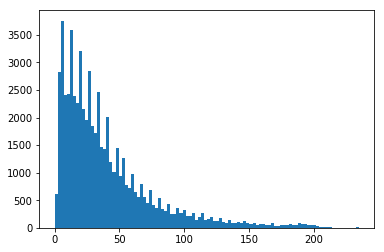

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=100);

In [44]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQ_LEN = 235

train_padded_seqs = pad_sequences(train_sequences, maxlen = MAX_SEQ_LEN)
test_padded_seqs = pad_sequences(test_sequences, maxlen = MAX_SEQ_LEN)

print(train_padded_seqs.shape)
print(test_padded_seqs.shape)

(43280, 235)
(18549, 235)


In [51]:
from keras.layers import LSTM, Embedding, Dense, Input, SpatialDropout1D, Dropout

class LstmModel(NnModel):
    def __init__(self, train_vectors, train_labels, test_vectors, test_labels,
                 embedding_dim, memory_units):
        super().__init__(train_vectors, 
                         train_labels, 
                         test_vectors, 
                         test_labels)
        self.model = Sequential()
        self.model.add(Embedding(MAX_WORDS_NUM, embedding_dim, input_length = MAX_SEQ_LEN))
        self.model.add(Dropout(0.2))
        #self.model.add(SpatialDropout1D(0.2))
        self.model.add(LSTM(memory_units, dropout=0.2, recurrent_dropout=0.2))
        #self.model.add(LSTM(memory_units))
        self.model.add(Dense(188, activation='softmax'))
        self.model.summary()
        self.model.compile(optimizer="adam",
                           loss='categorical_crossentropy',
                           metrics=['acc'])        
    

In [52]:
lstm_model = LstmModel(train_padded_seqs, train_topic_labels, test_padded_seqs, test_topic_labels, 100, 100)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 235, 100)          4855300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 235, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 188)               18988     
Total params: 4,954,688
Trainable params: 4,954,688
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.train(15)

In [54]:
lstm_model.test()

              precision    recall  f1-score   support

           0       0.54      0.74      0.62       335
           1       0.30      0.68      0.41        41
           2       0.62      0.57      0.59        79
           3       0.26      0.23      0.25        39
           4       0.57      0.18      0.28        22
           5       0.63      0.74      0.68       106
           6       0.20      0.15      0.17       142
           7       0.59      0.35      0.44        62
           8       0.50      0.23      0.32        30
           9       0.12      0.27      0.17        22
          10       0.76      0.84      0.80       144
          11       0.25      0.03      0.06        29
          12       1.00      0.18      0.31        22
          13       0.43      0.13      0.20        45
          14       0.15      0.11      0.12        84
          15       0.33      0.06      0.11        16
          16       0.68      0.66      0.67       122
          17       0.57    

In [300]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

class CnnModel(NnModel):
     def __init__(self, train_vectors, train_labels, test_vectors, test_labels, 
                  embedding_dim, channels_num, conv_window):
        super().__init__(train_vectors, 
                         train_labels, 
                         test_vectors, 
                         test_labels)
        self.model = Sequential()
        self.model.add(Embedding(MAX_WORDS_NUM, embedding_dim, input_length = MAX_SEQ_LEN))
        self.model.add(Conv1D(channels_num, conv_window, activation='relu'))
        self.model.add(MaxPooling1D(conv_window))
        self.model.add(Flatten())
        self.model.add(Dense(188, activation='softmax'))
        self.model.summary()
        self.model.compile(optimizer=RMSprop(lr=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['acc'])        
    

In [301]:
cnn_model = CnnModel(train_padded_seqs, train_topic_labels, test_padded_seqs, test_topic_labels, 100, 128, 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 235, 100)          4855300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 231, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 46, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5888)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 188)               1107132   
Total params: 6,026,560
Trainable params: 6,026,560
Non-trainable params: 0
_________________________________________________________________


In [302]:
cnn_model.train()

InternalError: cudnn PoolBackward launch failed
	 [[{{node training_18/RMSprop/gradients/max_pooling1d_2/MaxPool_grad/MaxPoolGrad}}]]

In [ ]:
cnn_model.test()

In [28]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_topic_labels),
                                                 train_topic_labels)

In [33]:
EMBEDDING_DIM = 100
MAX_WORDS_NUM = len(vocab) + 1




added 62930 words in the embedding matrix


In [55]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
#model.add(pretrained_embedding_layer)
model.add(layers.Embedding(MAX_NB_WORDS, 64, input_length=MAX_SEQUENCE_LENGTH))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dense(188, activation='softmax'))
#model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 211, 64)           7164544   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 205, 32)           14368     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 41, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 188)               6204      
Total params: 7,192,316
Trainable params: 7,192,316
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = MAX_NB_WORDS #min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tqdm_notebook(vocab.token2id.items()):
    #if i >= MAX_NB_WORDS:
    #    continue
    embedding_vector = None
    try:
        embedding_vector = wv[word]
    except KeyError as e:
        pass
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)